In [44]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
from sklearn.decomposition import PCA
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

# Data load
Hand cleaned to removed duplicates.  

In [2]:
cleansed=load_amihud_markets_price()
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:162: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:43: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:45: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:47: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,win

# PCA Analysis


In [26]:
ind=amihud['Soybean Oil'].dropna().index
temp=amihud.ix[ind].dropna(axis=1)
x=temp.max()
x.sort_values()
removed_noise=x.tail(5).index
temp=temp[temp.columns.drop(removed_noise)]

In [34]:
ct=amihud.count()
ct.sort_values()
ct[ct>180].head()

CME-3 MTH EURODOLLAR COMP.    208
SFE-AUST 90 DAY BANK BILLS    211
EUREX-EURO SCHATZ             211
EUREX-EURO BOBL               211
TSE-10 YEAR T-BOND            211
dtype: int64

In [41]:
def calc_zscore_expanding_window(df):
    return (df-pd.rolling_mean(df,100000000,min_periods=1))/pd.rolling_std(df,100000000,min_periods=1)

# Standardize factors by rolling zscore
I use expanding window as per Korajczyk and Sadka 2008

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=1,window=100000000,center=False).mean()
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=1,window=100000000,center=False).std()
  


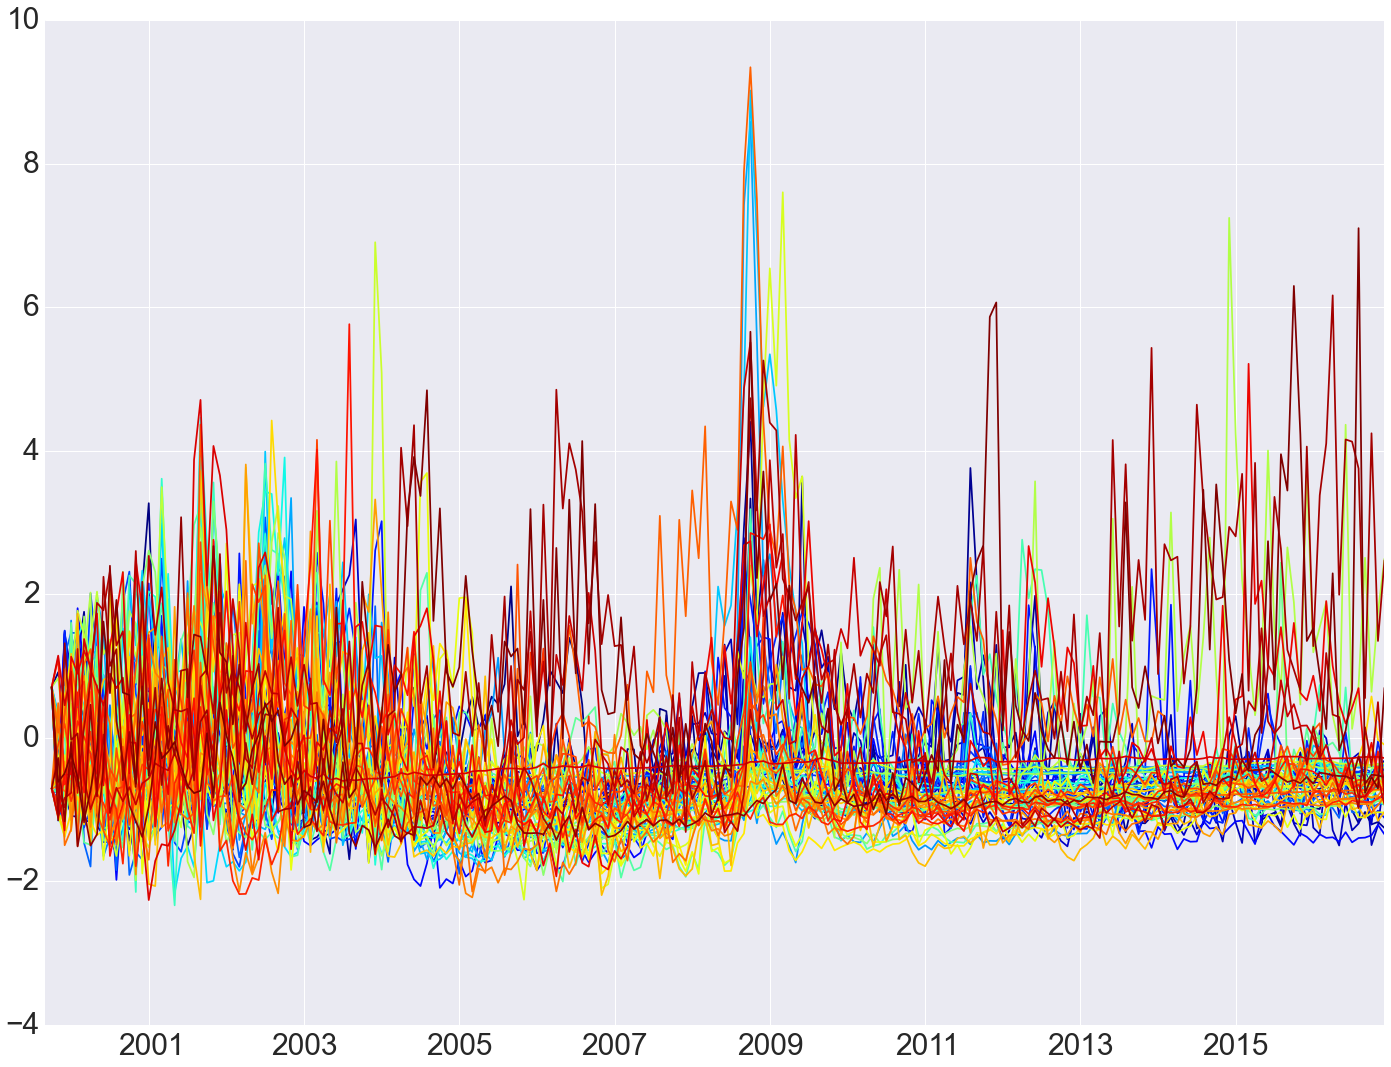

In [46]:
calc_zscore_expanding_window(temp).plot(colormap='jet',legend=False)

In [57]:
zscore_markets=calc_zscore_expanding_window(temp)
zscore_sector=pd.DataFrame()
d_map=sector_map(zscore_markets)
for sect in d_map.keys():
    zscore_sector[sect]=zscore_markets[d_map[sect]].mean(axis=1)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=1,window=100000000,center=False).mean()
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=1,window=100000000,center=False).std()
  


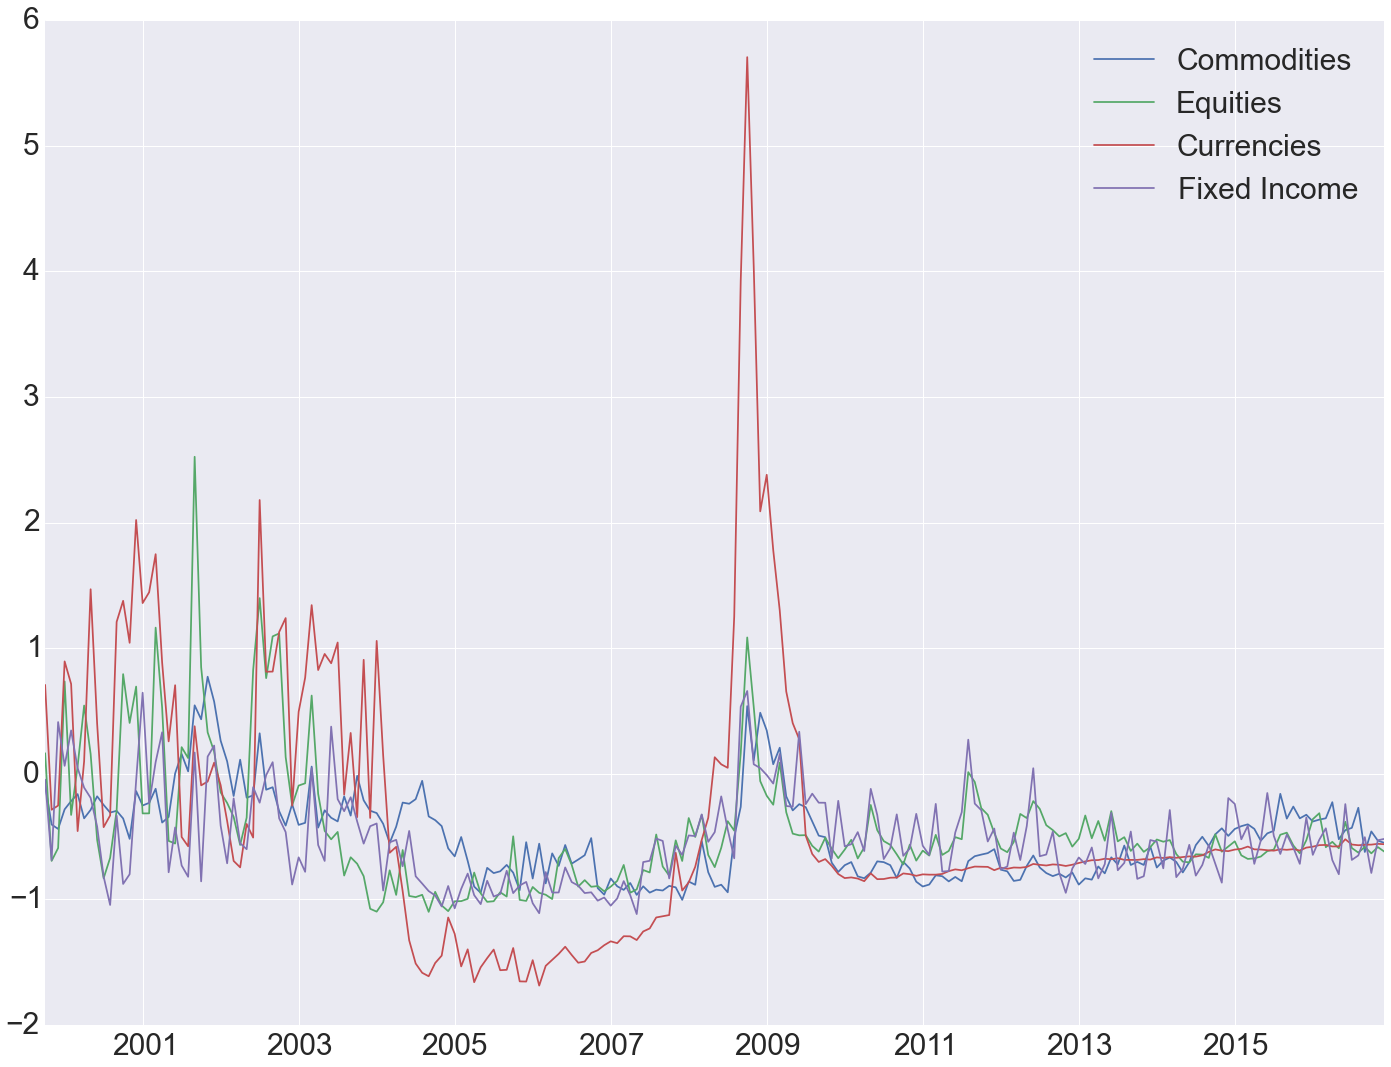

In [58]:
zscore_sector.dropna().plot(title='Rolling Zscore')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=1,window=100000000,center=False).mean()
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=1,window=100000000,center=False).std()
  


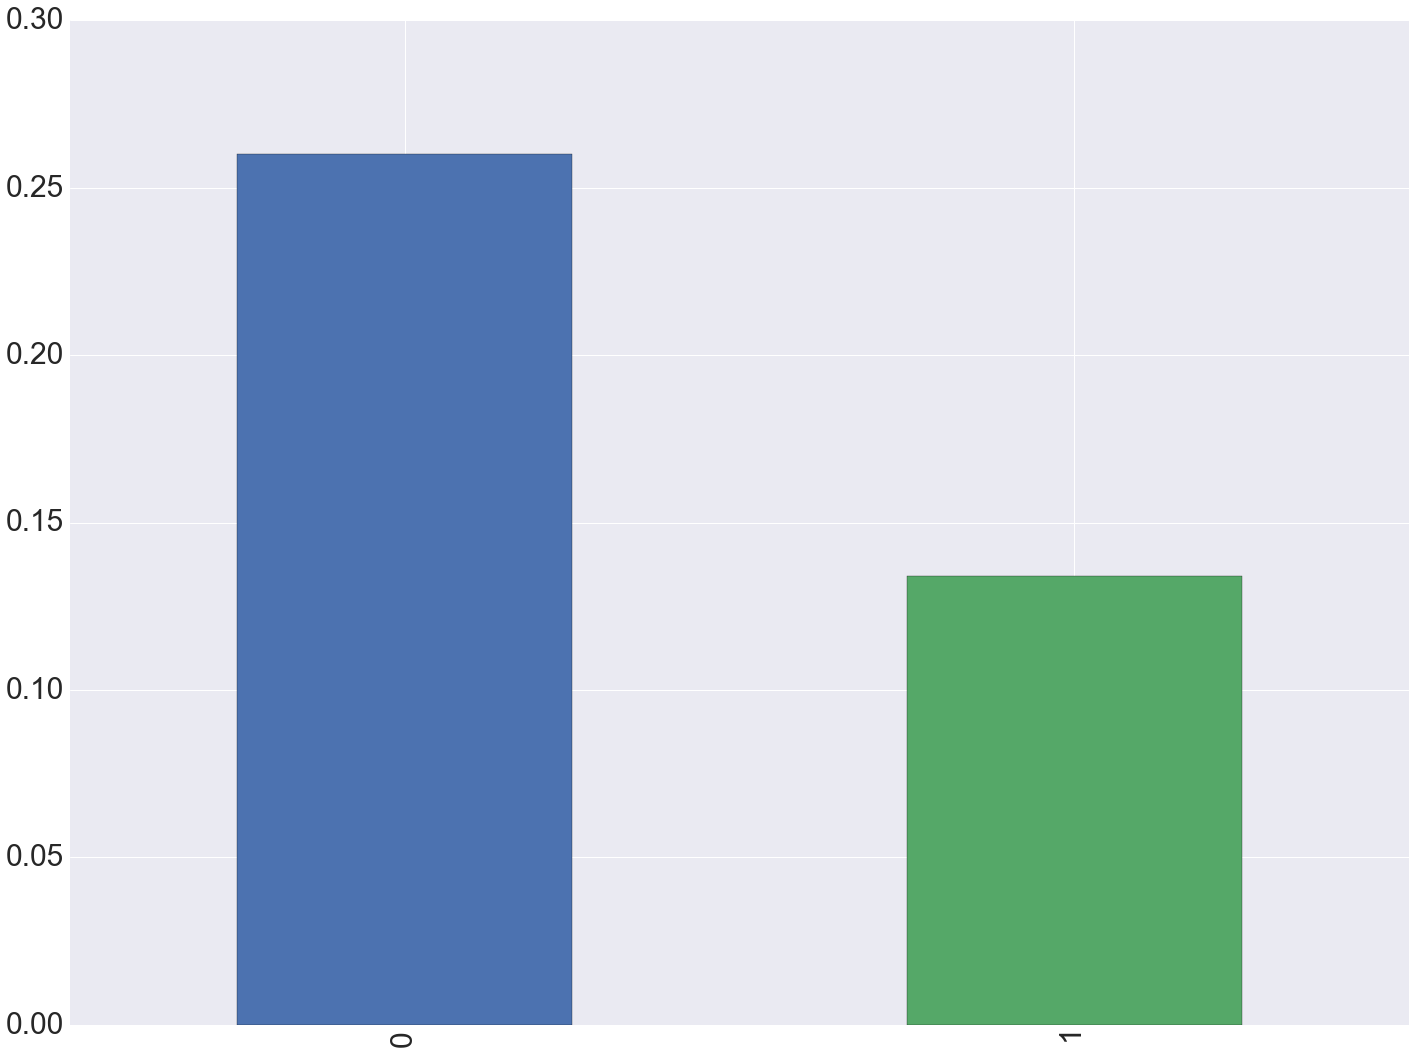

In [52]:
components=2
pca=PCA(n_components=components)
pca.fit(calc_zscore_expanding_window(temp).dropna())
pd.Series(pca.explained_variance_ratio_).plot(kind='bar')

In [53]:
pca.explained_variance_ratio_

array([ 0.26000765,  0.13413754])

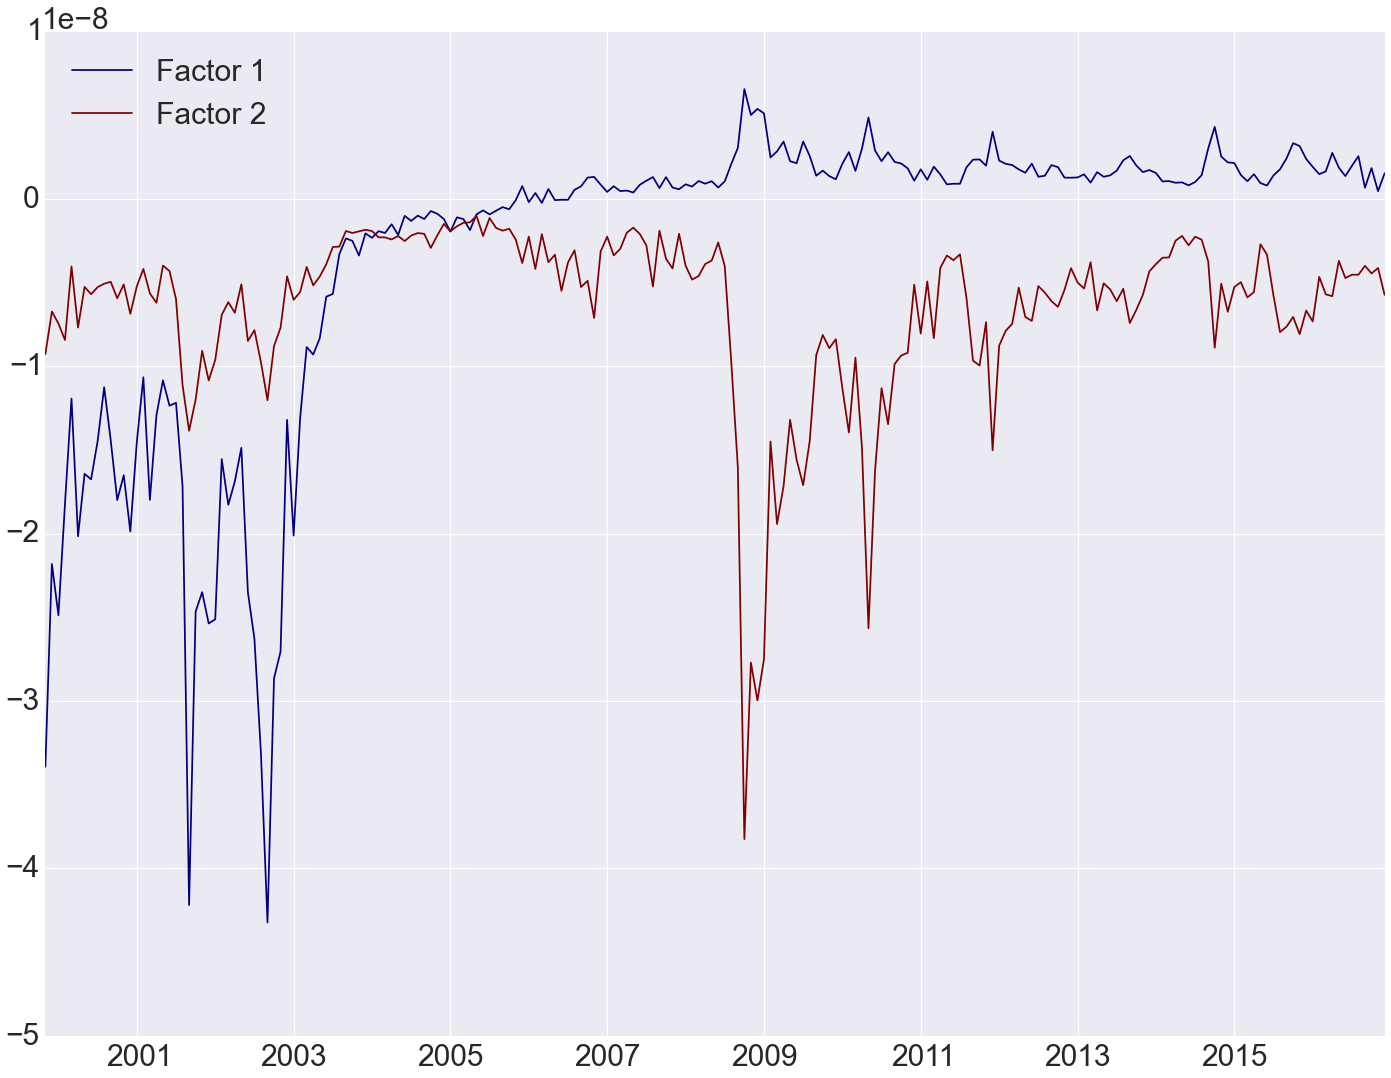

In [14]:
factor_rts=pd.DataFrame()
for i in range(0,components,1):
    q=pca.components_[i]
    factor_rts['Factor '+str(i+1)]=(q*temp.dropna()).sum(axis=1)
factor_rts.plot(colormap='jet')

In [15]:
factor_rts
ind=factor_rts.index
PS=pd.read_csv('PS.csv',parse_dates=[0]).set_index('Month').resample(rule='m',how='last')
VAR_PCA=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0])
VAR_PCA['Pastor and Stambaugh (2003)']=PS['Traded liquidity factor']
VAR_PCA['PCA Factor']=factor_rts['Factor 1']

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  app.launch_new_instance()


In [16]:
central_banks_asset=pd.DataFrame()
central_banks_asset['ECB']=pd.read_csv('ECBASSETS.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).ECBASSETS.resample(rule='m',how='last')
central_banks_asset['BOJ']=pd.read_csv('JPNASSETS.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).JPNASSETS.resample(rule='m',how='last') 
central_banks_asset['Fed']=pd.read_csv('WALCL.csv',
                                       parse_dates=['DATE'],
                                       index_col=['DATE']).WALCL.resample(rule='m',how='last')
fx=pd.DataFrame()
fx['BOJ']=quandl.get('CURRFX/USDJPY',authtoken=token).resample(rule='m',how='last').Rate/100
fx['ECB']=quandl.get('CURRFX/USDEUR',authtoken=token).resample(rule='m',how='last').Rate
fx['Fed']=1
VAR_PCA['Central Bank Assets']=(central_banks_asset/fx).dropna(how='all').sum(axis=1).resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: FutureWarning: how in .resample() is deprecated
the 

In [17]:
temp=VAR_PCA.ix[ind]

In [41]:
col=[ u'LIBOR', u'FinancialStress','Central Bank Assets',u'PCA Factor']

In [19]:
import statsmodels.tsa.vector_ar.var_model as VAR
res = VAR.VAR(endog=temp[col].dropna()).fit()
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 22, Oct, 2017
Time:                     23:12:13
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -18.3001
Nobs:                     190.000    HQIC:                  -18.5034
Log likelihood:           712.583    FPE:                8.01614e-09
AIC:                     -18.6419    Det(Omega_mle):     7.22506e-09
--------------------------------------------------------------------
Results for equation LIBOR
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.707375         0.191498            3.694           0.000
L1.LIBOR                       0.868842         0.032103           27.064           0.000
L1.FinancialStress      

In [20]:
model = VAR.VAR(endog=temp[col].dropna())
model.select_order(24)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -9.321       -9.247    8.948e-05       -9.291
1        -20.67       -20.30    1.053e-09       -20.52
2        -22.03       -21.35    2.718e-10       -21.75
3        -22.34      -21.37*    1.991e-10      -21.94*
4       -22.36*       -21.09   1.947e-10*       -21.85
5        -22.17       -20.60    2.371e-10       -21.53
6        -21.99       -20.12    2.845e-10       -21.23
7        -21.96       -19.79    2.951e-10       -21.08
8        -20.60       -18.13    1.156e-09       -19.60
9        -15.81       -13.05    1.400e-07       -14.69
10       -16.01       -12.95    1.163e-07       -14.77
11       -16.61       -13.25    6.462e-08       -15.25
12       -16.30       -12.64    8.913e-08       -14.82
13       -16.40       -12.44    8.242e-08       -14.80
14       -16.34       -12.09    8.958e-08       -14.61
15       -

{'aic': 4, 'bic': 3, 'fpe': 4, 'hqic': 3}

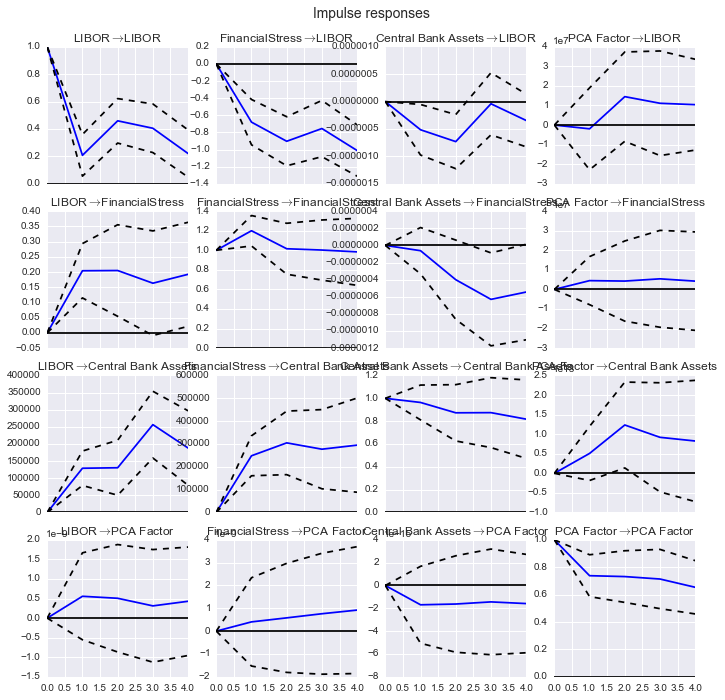

In [21]:

resaic = model.fit(maxlags=4,ic='aic')
irf=resaic.irf(4)
sns.set(font_scale=1)
irf.plot()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


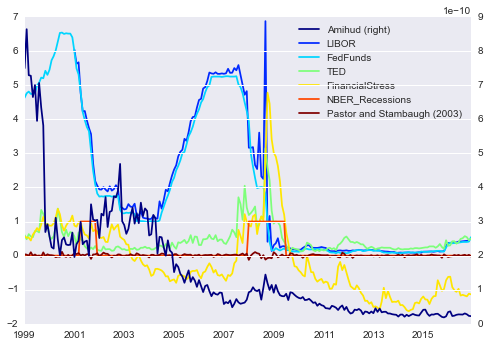

In [22]:
PS=pd.read_csv('PS.csv',parse_dates=[0]).set_index('Month').resample(rule='m',how='last')
factors=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0])
factors['Pastor and Stambaugh (2003)']=PS['Traded liquidity factor']
factors.plot(secondary_y='Amihud',colormap='jet')

In [23]:
for i in range(0,components,1):
    factors['PCA Factor '+ str(i+1)]=factor_rts['Factor '+str(i+1)]

/Users/mrefermat/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


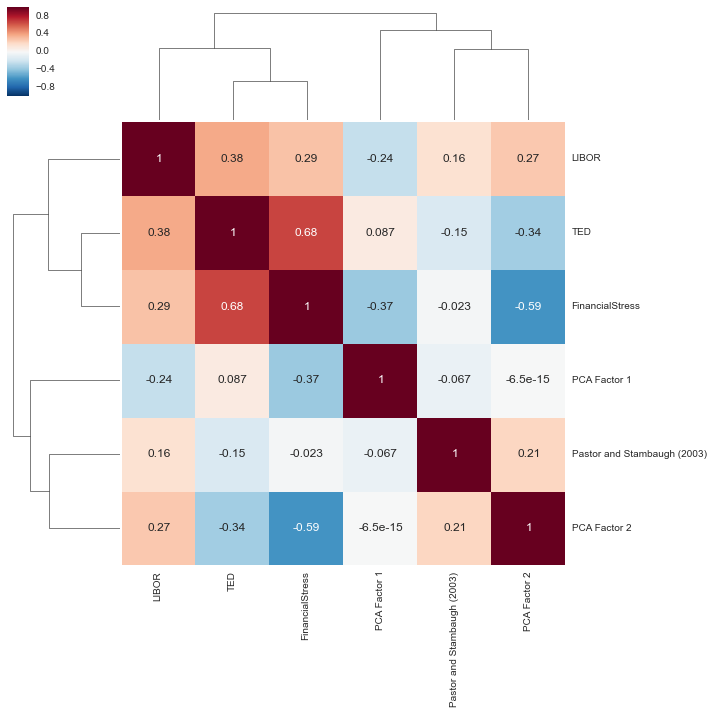

In [24]:
f=[u'LIBOR', u'TED', u'FinancialStress',
        u'Pastor and Stambaugh (2003)', u'PCA Factor 1',
       u'PCA Factor 2']
sns.clustermap(factors[f].corr(),annot=True)

In [25]:
f=[u'LIBOR', u'TED', u'FinancialStress',
        u'Pastor and Stambaugh (2003)']

In [26]:
col=[u'Amihud', u'LIBOR', u'FinancialStress','Central Bank Assets']
factors['Intercept']=1
en=factors.dropna()


In [27]:
RES=pd.DataFrame()
for factor in f:
    res=sm.OLS(en['PCA Factor 1']*1e7,en[['Intercept',factor]]).fit()
    s=pd.Series()
    s['Intercept']=res.params.Intercept
    s['Intercept Tstat']=res.tvalues.Intercept
    s['Factor']=res.params[factor]
    s['Factor' + ' Tstat']=res.tvalues[factor]    
    s['R^2']=res.rsquared_adj
    RES[factor]=s 

res=sm.OLS(en['PCA Factor 1']*1e7,en[f]).fit()
s=pd.Series()

RES.round(2)

,LIBOR,TED,FinancialStress,Pastor and Stambaugh (2003)
Intercept,-0.00,-0.04,-0.03,-0.02
Intercept Tstat,-0.40,-4.61,-4.40,-3.15
Factor,-0.01,0.04,-0.02,-0.24
Factor Tstat,-3.36,3.03,-4.03,-1.43
R^2,0.05,0.04,0.07,0.01


In [28]:
print RES.round(2).to_latex()

\begin{tabular}{lrrrr}
\toprule
{} &  LIBOR &   TED &  FinancialStress &  Pastor and Stambaugh (2003) \\
\midrule
Intercept       &  -0.00 & -0.04 &            -0.03 &                        -0.02 \\
Intercept Tstat &  -0.40 & -4.61 &            -4.40 &                        -3.15 \\
Factor          &  -0.01 &  0.04 &            -0.02 &                        -0.24 \\
Factor Tstat    &  -3.36 &  3.03 &            -4.03 &                        -1.43 \\
R\textasciicircum2             &   0.05 &  0.04 &             0.07 &                         0.01 \\
\bottomrule
\end{tabular}



In [29]:
RES=pd.DataFrame()
for factor in f:
    res=sm.OLS(en['PCA Factor 2']*1e7,en[['Intercept',factor]]).fit()
    s=pd.Series()
    s['Intercept']=res.params.Intercept
    s['Intercept Tstat']=res.tvalues.Intercept
    s['Factor']=res.params[factor]
    s['Factor' + ' Tstat']=res.tvalues[factor]    
    s['R^2']=res.rsquared_adj
    RES[factor]=s   
RES.round(2)

,LIBOR,TED,FinancialStress,Pastor and Stambaugh (2003)
Intercept,-0.08,-0.05,-0.07,-0.07
Intercept Tstat,-15.47,-8.79,-23.33,-17.33
Factor,0.01,-0.05,-0.03,0.33
Factor Tstat,3.86,-5.29,-11.08,3.18
R^2,0.07,0.12,0.39,0.05


In [30]:
print RES.round(2).to_latex()

\begin{tabular}{lrrrr}
\toprule
{} &  LIBOR &   TED &  FinancialStress &  Pastor and Stambaugh (2003) \\
\midrule
Intercept       &  -0.08 & -0.05 &            -0.07 &                        -0.07 \\
Intercept Tstat & -15.47 & -8.79 &           -23.33 &                       -17.33 \\
Factor          &   0.01 & -0.05 &            -0.03 &                         0.33 \\
Factor Tstat    &   3.86 & -5.29 &           -11.08 &                         3.18 \\
R\textasciicircum2             &   0.07 &  0.12 &             0.39 &                         0.05 \\
\bottomrule
\end{tabular}



In [42]:
factor_rts
ind=factor_rts.index
PS=pd.read_csv('PS.csv',parse_dates=[0]).set_index('Month').resample(rule='m',how='last')
VAR_PCA=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0])
VAR_PCA['Pastor and Stambaugh (2003)']=PS['Traded liquidity factor']
VAR_PCA['PCA Factor']=factor_rts['Factor 2']
VAR_PCA['Central Bank Assets']=(central_banks_asset/fx).dropna(how='all').sum(axis=1).resample(rule='m',how='last')
temp=VAR_PCA.ix[ind]

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  app.launch_new_instance()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


In [43]:
import statsmodels.tsa.vector_ar.var_model as VAR
res = VAR.VAR(endog=temp[col].dropna()).fit()
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 22, Oct, 2017
Time:                     23:21:09
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -18.9115
Nobs:                     190.000    HQIC:                  -19.1148
Log likelihood:           770.666    FPE:                4.34948e-09
AIC:                     -19.2533    Det(Omega_mle):     3.92025e-09
--------------------------------------------------------------------
Results for equation LIBOR
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.502494         0.186130            2.700           0.008
L1.LIBOR                       0.884463         0.034063           25.966           0.000
L1.FinancialStress      

In [44]:
model = VAR.VAR(endog=temp[col].dropna())
model.select_order(24)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -8.681       -8.606    0.0001698       -8.651
1        -19.07       -18.70    5.211e-09       -18.92
2        -20.17      -19.50*    1.735e-09       -19.90
3        -20.36       -19.38    1.447e-09      -19.96*
4        -20.36       -19.09    1.449e-09       -19.84
5       -20.57*       -19.00   1.176e-09*       -19.93
6        -20.36       -18.49    1.451e-09       -19.60
7        -20.28       -18.11    1.585e-09       -19.40
8        -15.76       -13.30    1.461e-07       -14.76
9        -16.33       -13.56    8.357e-08       -15.21
10       -16.63       -13.57    6.223e-08       -15.39
11       -17.44       -14.08    2.805e-08       -16.08
12       -17.52       -13.86    2.631e-08       -16.04
13       -17.92       -13.96    1.803e-08       -16.32
14       -18.12       -13.86    1.516e-08       -16.39
15       -

{'aic': 5, 'bic': 2, 'fpe': 5, 'hqic': 3}

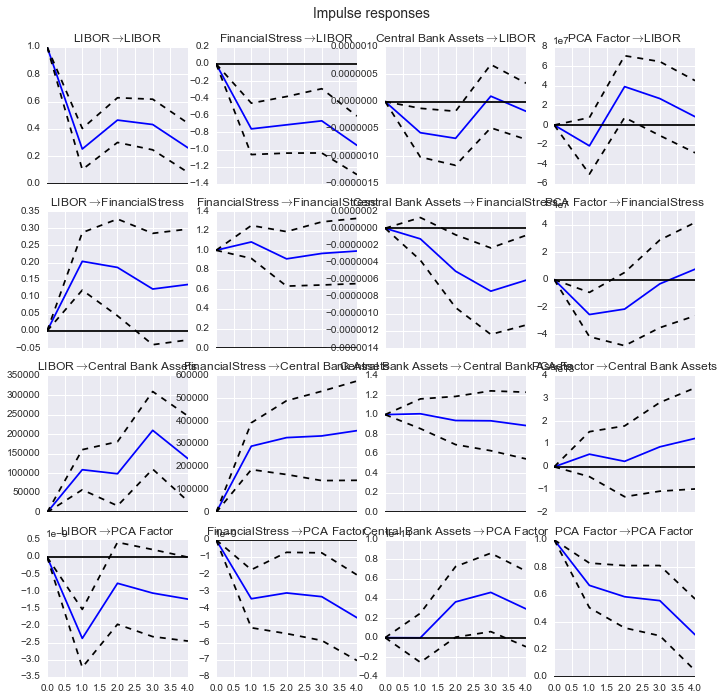

In [45]:
resaic = model.fit(maxlags=4,ic='aic')
irf=resaic.irf(4)
sns.set(font_scale=1)
irf.plot()